In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_quad_no_constraint import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 6
# problem_spec['vector_size'] = 10
# problem_spec['vector_size'] = 50
problem_spec['vector_size'] = 1
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()

problem_spec['sc_eps'] = 1

# PG-EXTRA hyperparameters
problem_data['rho'] = 2.5
problem_data['itr_num'] = 1000

{'n_node': 6, 'vector_size': 1}


In [3]:
Q = problem_data['Q']
b = problem_data['b']
n_node = problem_spec['n_node']
vector_size = problem_spec['vector_size']

for j in range(n_node):
    U, s, V = np.linalg.svd(Q[j])
    print([np.max(s), np.min(s)])

[0.007884780763549431, 0.007884780763549431]
[0.024088320716741357, 0.024088320716741357]
[0.0007126931518394324, 0.0007126931518394324]
[0.11528402360213955, 0.11528402360213955]
[0.10385398673276386, 0.10385398673276386]
[0.0037484982153688498, 0.0037484982153688498]


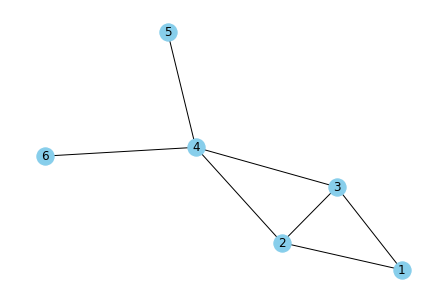

In [4]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True)
plt.savefig("plots/graph_n6.pdf")

In [5]:
f_star, x_opt_star = min_cvx_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-70.43016702460658, np.linalg.norm(x_opt_star)=57.50599056975996


In [6]:
f_star, x_opt_star = min_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

[[0.2555723]]
[[6.]]
[-23.47672234]
f_star=array([-70.43016702]), np.linalg.norm(x_opt_star)=23.476722341535535


In [7]:
c = np.random.randn(vector_size)
c

array([1.31446859])

In [8]:
b

[array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]])]

In [9]:
def fi(x,jj):
    return 1/2 * x @ Q[jj] @ x.T + np.dot(b[jj][0], x)


# fi(c,1)

fi_operators = []
for jj in range(n_node):
    fi_operators += [lambda x_kj : fi(x_kj,jj) ]
    print(fi_operators[-1](c))

1.3212803575560326
1.3352788198538645
1.3150842918617893
1.4140640490231278
1.4041894820679441
1.317706965848347


In [10]:
print(c)
print(Q[0])
print(b[0][0])

[1.31446859]
[[0.00788478]]
[1.]


In [11]:
print(np.dot(b[jj][0], c))
print(1/2 * c @ Q[0] @ c.T)
print(fi_operators[0](c))

1.3144685863897279
0.006811771166304635
1.317706965848347


In [12]:
c.T

array([1.31446859])

In [13]:
print(np.dot(b[0][0],c))
print( b[0][0] @ c )

1.3144685863897279
1.3144685863897279


In [14]:
Q = problem_data['Q']
b = problem_data['b']
 
vector_size = problem_spec['vector_size']
n_node = problem_spec['n_node']
eps = problem_spec['sc_eps']
prox_operators = []
fi_operators = []

# Define functions and proximal operators to implement the method
for jj in range(n_node):
    # prox_operators += [lambda z, rho: cvx_prox_fj_quad_no_constraint(z, rho, problem_spec, problem_data, jj) ]
    prox_operators += [lambda z, rho, problem_spec=problem_spec, problem_data=problem_data: prox_fj_quad_no_constraint(z, rho, problem_spec, problem_data, jj=jj) ]
    # fi_operators += [lambda x_kj : (1/2 * x_kj @ Q[jj] @ x_kj.T + b[jj] @ x_kj)[0] ]
    fi_operators += [lambda x_kj : fi(x_kj, jj) ]

    # c = np.random.randn(vector_size)
    x1 = prox_operators[-1](c, 1/5)
    x2 = cvx_prox_fj_quad_no_constraint(c, 1/5, problem_spec, problem_data, jj, eps=1e-4)
    print(fi_operators[-1](c))
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5

1.3212803575560326
1.3352788198538645
1.3150842918617893
1.4140640490231278
1.4041894820679441
1.317706965848347


In [15]:
params={"R":2, "Inductance":4, "Capacitance":4, "h":2.764408907848405}
# params={"R":18, "Inductance":10, "Capacitance":1, "h":1.0541046971920436}
# params={"R":18, "Inductance":10, "h":1.1054814693822324}
dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, freq=200)

ii=0, f_reldiff[-1]=array([0.90377961]), err_opt_reldiff[-1]=0.9132245254600895
ii=200, f_reldiff[-1]=array([6.98246651]), err_opt_reldiff[-1]=3.9949506205513083
ii=400, f_reldiff[-1]=array([9.35136685]), err_opt_reldiff[-1]=6.68742735960585
ii=600, f_reldiff[-1]=array([10.06042324]), err_opt_reldiff[-1]=8.160482330206731
ii=800, f_reldiff[-1]=array([10.27265714]), err_opt_reldiff[-1]=8.966391222495698
ii=999, f_reldiff[-1]=array([10.33601857]), err_opt_reldiff[-1]=9.405695657809678


In [16]:
# R = 18
# R = 1
R = 2
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=True, freq=200)

ii=0, f_reldiff[-1]=array([0.90377961]), err_opt_reldiff[-1]=0.9132245254600895
ii=200, f_reldiff[-1]=array([7.23388555]), err_opt_reldiff[-1]=4.220271224008714
ii=400, f_reldiff[-1]=array([9.49595413]), err_opt_reldiff[-1]=6.928736502291473
ii=600, f_reldiff[-1]=array([10.12291748]), err_opt_reldiff[-1]=8.354644367019489
ii=800, f_reldiff[-1]=array([10.29668897]), err_opt_reldiff[-1]=9.105332682886715
ii=999, f_reldiff[-1]=array([10.34473326]), err_opt_reldiff[-1]=9.499130869975366


In [17]:
# apply P-EXTRA 
# problem_data['rho'] = 1
problem_data['rho'] = 0.5
pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_quad_no_constraint(problem_spec, problem_data, network_data, x_opt_star, f_star, printing=True, freq=200)

ii=0, f_reldiff[-1]=array([1.04214286]), err_opt_reldiff[-1]=0.9791574536484051
ii=200, f_reldiff[-1]=array([9.29754743e-05]), err_opt_reldiff[-1]=0.014208954644992297
ii=400, f_reldiff[-1]=array([1.81835272e-06]), err_opt_reldiff[-1]=0.0002061745203983488
ii=600, f_reldiff[-1]=array([2.70511672e-08]), err_opt_reldiff[-1]=2.9916282007217365e-06
ii=800, f_reldiff[-1]=array([3.92657111e-10]), err_opt_reldiff[-1]=4.340847281972047e-08
ii=999, f_reldiff[-1]=array([5.81951583e-12]), err_opt_reldiff[-1]=6.426005671580582e-10


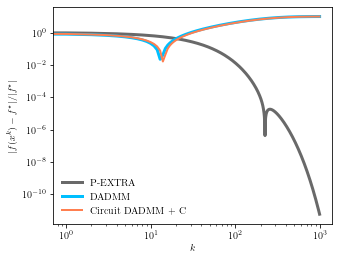

In [18]:
fname = "n6_circuit_dadmm_c"

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 4
plt.rcParams["legend.framealpha"] = 0.0
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["mathtext.fontset"] = 'cm' # default = 'dejavusans', other options = 'cm', 'stixsans', 'dejavuserif'
black, red, blue, green = 'dimgrey', 'coral', 'deepskyblue', 'gold'

# operator norm plot (log-log plot)
plt.figure(figsize=(5,4))
plt.minorticks_off()
plt.xscale("log")
plt.yscale("log")
plt.plot(pg_f_reldiff, label='P-EXTRA', color=black, linewidth=3)
plt.plot(admm_f_reldiff, label='DADMM', color=blue, linewidth=3)
# plt.plot(ciradmm_f_reldiff, label='Circuit DADMM',  color=green, linewidth=2)
plt.plot(dadmm_c_f_reldiff, label='Circuit DADMM + C',  color=red, linewidth=2)
plt.xlabel(r"$k$")
plt.ylabel(r"$|f(x^k) - f^\star|/|f^\star|$")
# plt.ylabel(r"$\|\tilde{\mathbf{A}}x_k\|^2_M$")
# plt.ylim(1e-7, 1e0)
plt.autoscale(enable=True, axis='y', tight=None)
plt.legend()
# plt.savefig(f'plots/freldif_{fname}.pdf', dpi=300)

In [19]:
a = []
a.append(1)
a[0] += 1
a[0]

2